In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer

In [2]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "TRF", "Submitted_for_Approval", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [89]:
def preprocess(data, ada = False):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days == 0
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    #data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
    
    data["Concrete_Offer"] = ((data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days) < 60
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    #data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        imputer = SimpleImputer(strategy = "mean")
        cols = data.columns
        data = imputer.fit_transform(data)
        data = pd.DataFrame(data, columns = cols)

    return (data)

In [90]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [91]:
prep = preprocess(data, ada=True)

In [93]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size = 0.3, random_state = 0)

In [94]:
model = xgb.XGBClassifier(learning_rate = 0.015,
                          subsample=0.7,
                          colsample_bytree=0.5,
                          scale_pos_weight=0.69,
                          random_state=42,
                          max_depth=8,
                          booster = 'gbtree',
                          objective = 'binary:logistic',
                          n_estimators = 5000)

In [95]:
model.fit(x_train.drop(target, axis = 1), 
          y_train, eval_metric = 'logloss', 
          eval_set=[(x_test.drop(target, axis = 1), y_test)], 
          early_stopping_rounds = 200)

[0]	validation_0-logloss:0.680176
Will train until validation_0-logloss hasn't improved in 200 rounds.
[1]	validation_0-logloss:0.672855
[2]	validation_0-logloss:0.665865
[3]	validation_0-logloss:0.653793
[4]	validation_0-logloss:0.647168
[5]	validation_0-logloss:0.640865
[6]	validation_0-logloss:0.633604
[7]	validation_0-logloss:0.622277
[8]	validation_0-logloss:0.615851
[9]	validation_0-logloss:0.605123
[10]	validation_0-logloss:0.599209
[11]	validation_0-logloss:0.593762
[12]	validation_0-logloss:0.583578
[13]	validation_0-logloss:0.578487
[14]	validation_0-logloss:0.568681
[15]	validation_0-logloss:0.559045
[16]	validation_0-logloss:0.554053
[17]	validation_0-logloss:0.549098
[18]	validation_0-logloss:0.543924
[19]	validation_0-logloss:0.534909
[20]	validation_0-logloss:0.526069
[21]	validation_0-logloss:0.517584
[22]	validation_0-logloss:0.509367
[23]	validation_0-logloss:0.501288
[24]	validation_0-logloss:0.496788
[25]	validation_0-logloss:0.489016
[26]	validation_0-logloss:0.484

[230]	validation_0-logloss:0.110739
[231]	validation_0-logloss:0.110245
[232]	validation_0-logloss:0.109991
[233]	validation_0-logloss:0.109501
[234]	validation_0-logloss:0.109308
[235]	validation_0-logloss:0.109158
[236]	validation_0-logloss:0.108956
[237]	validation_0-logloss:0.108826
[238]	validation_0-logloss:0.108333
[239]	validation_0-logloss:0.108159
[240]	validation_0-logloss:0.107993
[241]	validation_0-logloss:0.107894
[242]	validation_0-logloss:0.107654
[243]	validation_0-logloss:0.1075
[244]	validation_0-logloss:0.107413
[245]	validation_0-logloss:0.106959
[246]	validation_0-logloss:0.106823
[247]	validation_0-logloss:0.106684
[248]	validation_0-logloss:0.10623
[249]	validation_0-logloss:0.105794
[250]	validation_0-logloss:0.105671
[251]	validation_0-logloss:0.105451
[252]	validation_0-logloss:0.105289
[253]	validation_0-logloss:0.104818
[254]	validation_0-logloss:0.10465
[255]	validation_0-logloss:0.104486
[256]	validation_0-logloss:0.104355
[257]	validation_0-logloss:0.103

[459]	validation_0-logloss:0.075333
[460]	validation_0-logloss:0.075256
[461]	validation_0-logloss:0.075184
[462]	validation_0-logloss:0.075164
[463]	validation_0-logloss:0.075109
[464]	validation_0-logloss:0.075059
[465]	validation_0-logloss:0.075042
[466]	validation_0-logloss:0.075005
[467]	validation_0-logloss:0.074932
[468]	validation_0-logloss:0.074896
[469]	validation_0-logloss:0.074855
[470]	validation_0-logloss:0.07482
[471]	validation_0-logloss:0.074729
[472]	validation_0-logloss:0.07469
[473]	validation_0-logloss:0.074584
[474]	validation_0-logloss:0.07454
[475]	validation_0-logloss:0.074496
[476]	validation_0-logloss:0.074424
[477]	validation_0-logloss:0.074347
[478]	validation_0-logloss:0.074264
[479]	validation_0-logloss:0.074227
[480]	validation_0-logloss:0.074132
[481]	validation_0-logloss:0.074031
[482]	validation_0-logloss:0.073969
[483]	validation_0-logloss:0.073895
[484]	validation_0-logloss:0.073845
[485]	validation_0-logloss:0.073755
[486]	validation_0-logloss:0.07

[688]	validation_0-logloss:0.066131
[689]	validation_0-logloss:0.066119
[690]	validation_0-logloss:0.066099
[691]	validation_0-logloss:0.066059
[692]	validation_0-logloss:0.066026
[693]	validation_0-logloss:0.066027
[694]	validation_0-logloss:0.066025
[695]	validation_0-logloss:0.066017
[696]	validation_0-logloss:0.066003
[697]	validation_0-logloss:0.065994
[698]	validation_0-logloss:0.065995
[699]	validation_0-logloss:0.065991
[700]	validation_0-logloss:0.066
[701]	validation_0-logloss:0.065971
[702]	validation_0-logloss:0.065956
[703]	validation_0-logloss:0.065924
[704]	validation_0-logloss:0.065892
[705]	validation_0-logloss:0.065876
[706]	validation_0-logloss:0.065831
[707]	validation_0-logloss:0.065829
[708]	validation_0-logloss:0.065804
[709]	validation_0-logloss:0.065798
[710]	validation_0-logloss:0.065748
[711]	validation_0-logloss:0.065701
[712]	validation_0-logloss:0.065693
[713]	validation_0-logloss:0.065667
[714]	validation_0-logloss:0.065655
[715]	validation_0-logloss:0.06

[917]	validation_0-logloss:0.062975
[918]	validation_0-logloss:0.062958
[919]	validation_0-logloss:0.062936
[920]	validation_0-logloss:0.062915
[921]	validation_0-logloss:0.062919
[922]	validation_0-logloss:0.062894
[923]	validation_0-logloss:0.062884
[924]	validation_0-logloss:0.062878
[925]	validation_0-logloss:0.062854
[926]	validation_0-logloss:0.062856
[927]	validation_0-logloss:0.062855
[928]	validation_0-logloss:0.062865
[929]	validation_0-logloss:0.06284
[930]	validation_0-logloss:0.062835
[931]	validation_0-logloss:0.062839
[932]	validation_0-logloss:0.062855
[933]	validation_0-logloss:0.062835
[934]	validation_0-logloss:0.062825
[935]	validation_0-logloss:0.062819
[936]	validation_0-logloss:0.062813
[937]	validation_0-logloss:0.062805
[938]	validation_0-logloss:0.062798
[939]	validation_0-logloss:0.0628
[940]	validation_0-logloss:0.062794
[941]	validation_0-logloss:0.062794
[942]	validation_0-logloss:0.062789
[943]	validation_0-logloss:0.062787
[944]	validation_0-logloss:0.06

[1142]	validation_0-logloss:0.061914
[1143]	validation_0-logloss:0.061903
[1144]	validation_0-logloss:0.0619
[1145]	validation_0-logloss:0.061886
[1146]	validation_0-logloss:0.061858
[1147]	validation_0-logloss:0.061837
[1148]	validation_0-logloss:0.061842
[1149]	validation_0-logloss:0.061835
[1150]	validation_0-logloss:0.061816
[1151]	validation_0-logloss:0.061807
[1152]	validation_0-logloss:0.061807
[1153]	validation_0-logloss:0.06182
[1154]	validation_0-logloss:0.061803
[1155]	validation_0-logloss:0.061794
[1156]	validation_0-logloss:0.061789
[1157]	validation_0-logloss:0.061784
[1158]	validation_0-logloss:0.061776
[1159]	validation_0-logloss:0.061761
[1160]	validation_0-logloss:0.061746
[1161]	validation_0-logloss:0.061756
[1162]	validation_0-logloss:0.061761
[1163]	validation_0-logloss:0.061748
[1164]	validation_0-logloss:0.061737
[1165]	validation_0-logloss:0.06174
[1166]	validation_0-logloss:0.061738
[1167]	validation_0-logloss:0.061742
[1168]	validation_0-logloss:0.061768
[1169

Stopping. Best iteration:
[1164]	validation_0-logloss:0.061737



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.015,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=5000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.69, seed=None, silent=True,
       subsample=0.7)

In [96]:
res = model.predict_proba(x_test.drop(target, axis=1))[:,1]

In [10]:
x_test.Stage.head(10)

2040     0.0
4069     0.0
4230     1.0
578      1.0
12594    0.0
6042     1.0
2763     0.0
15900    0.0
2669     1.0
12802    0.0
Name: Stage, dtype: float64

In [97]:
for x in res[:10]:
    print("{:f}".format(x))

0.000640
0.006717
0.998178
0.988821
0.217032
0.960576
0.003356
0.000100
0.998388
0.000517


In [98]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [99]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [100]:
log_loss(answer["Stage"], answer["Prediction"])

0.07040809798021824

31


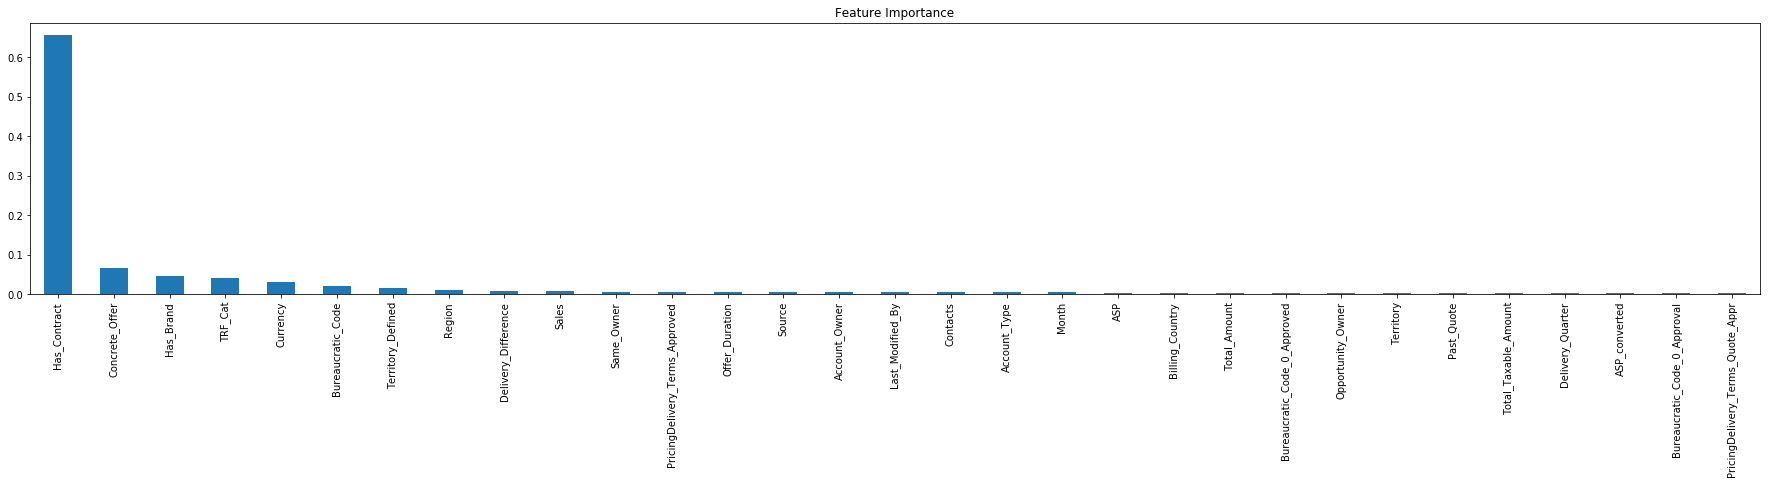

In [101]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
print len(predictors)
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:31]
plt.rcParams['figure.figsize'] = 31, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [102]:
print feat_imp

Has_Contract                        0.654998
Concrete_Offer                      0.065367
Has_Brand                           0.046475
TRF_Cat                             0.042217
Currency                            0.030232
Bureaucratic_Code                   0.022139
Territory_Defined                   0.016530
Region                              0.009883
Delivery_Difference                 0.009351
Sales                               0.007608
Same_Owner                          0.006814
PricingDelivery_Terms_Approved      0.006305
Offer_Duration                      0.006203
Source                              0.005084
Account_Owner                       0.004916
Last_Modified_By                    0.004824
Contacts                            0.004821
Account_Type                        0.004644
Month                               0.004621
ASP                                 0.004505
Billing_Country                     0.004474
Total_Amount                        0.004433
Bureaucrat

In [103]:
vali = pd.read_csv("Validacion_ECI_2020.csv")

In [104]:
validation = preprocess(vali, ada = True)

In [779]:
len(validation[validation.Contacts > 0])

2551

In [105]:
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))

In [106]:
pred_vali = pred[:,1]

In [108]:
pred = pd.DataFrame(pred_vali, index = validation.index, columns = ["Prediction"])
pred_vali = validation.join(pred)

In [109]:
answer = pd.DataFrame(pred_vali.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [110]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9961165916958729

In [111]:
answer["Opportunity_ID"] = answer["Opportunity_ID"].astype(int)

In [112]:
answer.to_csv("fabri/xgb3.csv", index = False, header = False)